# Projet - Real or Not? NLP with Disaster Tweets

## 1.Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

Data Description
What files do I need?
You'll need train.csv, test.csv and sample_submission.csv.

What should I expect the data format to be?
Each sample in the train and test set has the following information:

The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)
What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

Files
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format
Columns
id - a unique identifier for each tweet
text - the text of the tweet
location - the location the tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# TensorFlow installation
!pip install tensorflow

## 2.Exploratory Data Analysis

### 2.1 Import librairies

In [3]:
#import librairies
import pandas as pd
import re
from spacy.lang.en.stop_words import STOP_WORDS
import warnings
warnings.filterwarnings("ignore")

#Libraries for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Library for Splitting Dataset
from sklearn.model_selection import train_test_split

#Deep learning
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPool1D


2022-02-17 09:05:57.884829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 09:05:57.884954: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 2.2 Import Datasets

In [4]:
#import dataset
df = pd.read_csv("src/train.csv")
df.sample(5)

,id,keyword,location,text,target
3169,4548,emergency%20plan,"Antioch, CA",4 Printable Emergency Plan Templates\nhttp://t...,0
5247,7503,oil%20spill,California,Refugio oil spill may have been costlier bigge...,1
2001,2877,damage,"Marysville, MI",Let's say a tree falls on your fence. Do you k...,0
2557,3666,destroy,UK,#YIAYplan Use my awesome collection of Amiibos...,0
6079,8685,sinkhole,"ÌÏT: 42.910975,-78.865828",Does that sewer look like it's sinking to you?...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### 2.3 Target Identification

In [6]:
#Target Distributions
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
#Target == 0
df['text'][df['target']==0]

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

In [8]:
#Target == 1
df['text'][df['target']==1]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3271, dtype: object

Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster || 1: Disaster)')

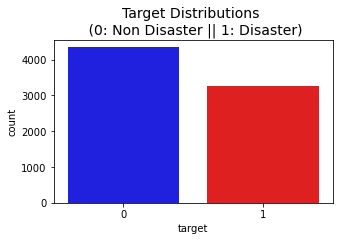

In [9]:
#0: Non Disaster
#1: Disaster

plt.figure(figsize=(5,3))
colors = ["blue", "red"]

sns.countplot(x = 'target', data=df, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster || 1: Disaster)', fontsize=14)

## 3.Text Preprocessing

In [10]:
df = df[['id','text','target']]
df.sample(5)

,id,text,target
6499,9292,Hank Williams Jr. - 'Country Boys Can Survive'...,0
3386,4848,ÛÏA voluntary evacuation is being recommended...,1
7146,10241,Brian Shaw + J.J. Hickson + Kenneth Faried try...,0
7192,10304,Iranian warship points weapon at U.S. helicopt...,1
3749,5326,I See Fire,0


### 3.1 Remove punctuation digits in text

In [11]:
#remove punctuation digits in text
def text_clean(text):
  text = text.lower()
  text = text.replace("'"," ")
  text = re.sub(r'<.*?>', '', text)         # remove html tags
  text = re.sub(r'https?://\S+', '', text)  # remove link
  text = re.sub(r'[0-9,.]+', '', text)      # remove digits
  text = re.sub(r'@\S+', '', text)          # remove tweeted at
  text = re.sub('\s+', ' ', text).strip()   # remove leading, trailing, and extra spaces
  text = re.sub(r'[^\w\s]','',text)         # remove punctuation
 
  return text

In [12]:
df['clean_text'] = df['text'].apply(text_clean)
df

,id,text,target,clean_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,the out of control wild fires in california ev...
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utckm s of volcano hawaii
7611,10872,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...


### 3.2 Remove Stopwords

In [13]:
#remove stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOP_WORDS])

In [14]:
df['clean_text_stopwords'] = df['clean_text'].apply(remove_stopwords)
df

,id,text,target,clean_text,clean_text_stopwords
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,deeds reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,residents asked shelter place notified officer...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,people receive wildfires evacuation orders cal...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,giant cranes holding bridge collapse nearby homes
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,the out of control wild fires in california ev...,control wild fires california northern state t...
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utckm s of volcano hawaii,m utckm s volcano hawaii
7611,10872,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,police investigating ebike collided car little...


### 3.3 Tokenization

In [15]:
# create a tokenizer instance
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer

In [16]:
#Fit the tokenizer on your texts
tokenizer.fit_on_texts(df['clean_text_stopwords'])

In [17]:
#tokenizer.word_index

In [18]:
# Now encode your texts using `texts_to_sequences` and store the result in a new column of the DataFrame.
df['token_encoded'] = tokenizer.texts_to_sequences(df['clean_text_stopwords'])
df.sample(5)

,id,text,target,clean_text,clean_text_stopwords,token_encoded
6641,9509,@rahulkanwal why Jammu is soft target for ter...,1,why jammu is soft target for terrorist,jammu soft target terrorist,"[13621, 4460, 1472, 203]"
7023,10067,Obama Declares Disaster for Typhoon-Devastated...,1,obama declares disaster for typhoondevastated ...,obama declares disaster typhoondevastated saip...,"[80, 480, 13, 533, 534, 80, 576, 13, 715, 79, ..."
2563,3676,@SarniamakChris @Hromadske @kasiadear33 how s...,1,how silly that one of only two countries that ...,silly countries destroy world world security,"[9098, 2257, 189, 29, 29, 392]"
2248,3218,Businesses are deluged with invoices. Make you...,0,businesses are deluged with invoices make your...,businesses deluged invoices stand colour shape...,"[846, 504, 1586, 623, 1284, 1111, 1, 845, 8666..."
6939,9950,@PrinceofFencing frickin summer and its humidi...,0,frickin summer and its humidity building up an...,frickin summer humidity building causing trouble,"[13938, 166, 2940, 407, 1100, 333]"


In [19]:
# Define the vocabulary size and number of words in a sequence
vocab_size = len(list(set(' '.join([x for x in df.clean_text_stopwords.values]).split())))
print('vocab_size : ', vocab_size)

# length of the longest tokenized tweet : 
sequence_length = max([len(x.split()) for x in df.clean_text_stopwords])
print('sequence_length : ', sequence_length)

vocab_size :  14644
sequence_length :  21


### 3.4 Padding

In [20]:
#Padding
df_pad = tf.keras.preprocessing.sequence.pad_sequences(df.token_encoded, maxlen=sequence_length, padding="post")
df_pad

array([[4055,  638,  119, ...,    0,    0,    0],
       [  76,    6,  106, ...,    0,    0,    0],
       [1448, 1330, 1816, ...,    0,    0,    0],
       ...,
       [   5, 3763,    1, ...,    0,    0,    0],
       [  14,  891, 2803, ...,    0,    0,    0],
       [  91,   87,  375, ...,    0,    0,    0]], dtype=int32)

### 3.5 Create the tensor dataset

In [21]:
#Now that your sequences are padded create the tensor dataset
all_encoded_data = tf.data.Dataset.from_tensor_slices((df_pad, df.target))

2022-02-17 09:07:10.595336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-17 09:07:10.595419: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-17 09:07:10.595504: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-g-2eyang-40live-2efr): /proc/driver/nvidia/version does not exist
2022-02-17 09:07:10.620976: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3.5 Train Test Split Dataset

In [22]:
TAKE_SIZE = int(len(df["target"])*0.8)
batch_size = 64

#shuffle the data
all_encoded_data = all_encoded_data.shuffle(len(df["target"]))

# Train Test Split
train_data = all_encoded_data.take(TAKE_SIZE)
train_data = train_data.batch(batch_size)

test_data = all_encoded_data.skip(TAKE_SIZE)
test_data = test_data.batch(batch_size)

In [23]:
 # Let's look at a batch 
for i in train_data.take(1):
  print(i)

(<tf.Tensor: shape=(64, 21), dtype=int32, numpy=
array([[ 1718, 13445,    86, ...,     0,     0,     0],
       [   60,   516,   125, ...,     0,     0,     0],
       [   47,    61,     3, ...,     0,     0,     0],
       ...,
       [   10,  1226,  2309, ...,     0,     0,     0],
       [ 3949,  3041,   206, ...,     0,     0,     0],
       [  821, 14063,  6017, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])>)


## 4. Modeling

Let's create a model based on an LSTM layer 

### 4.1 Model LSTM

In [24]:
model = Sequential()
model.add(Embedding(vocab_size +1, batch_size, name="embedding"))
# the input dim needs to be equal to the size of the vocabulary + 1 (because of the zero padding)
model.add(tf.keras.layers.Dropout(0.2))

# Bidirectional LSTM layer

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(16, return_sequences=False)) 
model.add(tf.keras.layers.Dropout(0.2))

# model.add(Dense(64,activation="relu"))
# model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(8,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

adam = tf.keras.optimizers.Adam(learning_rate=0.0005)


METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),]


model.compile(optimizer=adam,
              loss="binary_crossentropy",
               metrics = METRICS)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          937280    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         24832     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                5184      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                        

### 4.2 Model training

In [ ]:
# training
history = model.fit(train_data, epochs=30, validation_data=test_data)

Epoch 1/30
96/96 [==============================] - 13s 66ms/step - loss: 0.6695 - accuracy: 0.5764 - precision: 1.0000 - recall: 0.0035 - val_loss: 0.5611 - val_accuracy: 0.6894 - val_precision: 0.9737 - val_recall: 0.2833
Epoch 2/30
96/96 [==============================] - 5s 47ms/step - loss: 0.4938 - accuracy: 0.8100 - precision: 0.7975 - recall: 0.7557 - val_loss: 0.3507 - val_accuracy: 0.8759 - val_precision: 0.8964 - val_recall: 0.8009
Epoch 3/30
96/96 [==============================] - 5s 50ms/step - loss: 0.3246 - accuracy: 0.8790 - precision: 0.8725 - recall: 0.8415 - val_loss: 0.2309 - val_accuracy: 0.9271 - val_precision: 0.9287 - val_recall: 0.8953
Epoch 4/30
96/96 [==============================] - 5s 50ms/step - loss: 0.2394 - accuracy: 0.9154 - precision: 0.9149 - recall: 0.8859 - val_loss: 0.1714 - val_accuracy: 0.9488 - val_precision: 0.9578 - val_recall: 0.9190
Epoch 5/30
96/96 [==============================] - 5s 48ms/step - loss: 0.1819 - accuracy: 0.9411 - precis

In [29]:
#save training
model.save_weights('best_weights.h5')

In [30]:
h = pd.DataFrame.from_dict(history.history)
h.to_csv('history_model1.csv')

### 4.3 Evaluation

<AxesSubplot:>

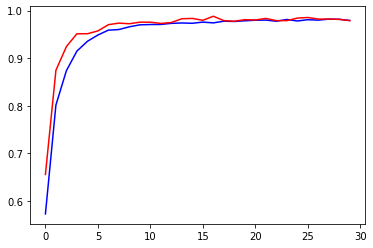

In [31]:
# Visualization of the training on the accuracy 
h.accuracy.plot(color="b")
h.val_accuracy.plot(color="r")

<AxesSubplot:>

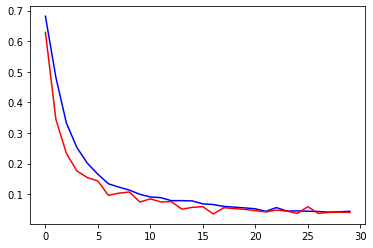

In [32]:
# Visualization of the training on the loss 
h.loss.plot(color="b")
h.val_loss.plot(color="r")